# Benchmark: PXD014777 HeLa 10 replicate dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 HeLa 10 replicate dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777).

In [30]:
%%capture

%matplotlib inline

import pipp
import pandas as pd
import umap
import matplotlib.pyplot as plt
import re

import numpy as np

Let's define the paths to the data and the pretrained model.

In [3]:
EVIDENCE_PATH = "../../data/txt/evidence.txt"
PEPTIDES_PATH = "../../data/txt/allPeptides.txt"

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

Let's load and clean the data.

In [4]:
evidence = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0)
peptides = pd.read_csv(PEPTIDES_PATH, sep='\t', header=0)

/tmp/ipykernel_22340/1775197305.py:1: DtypeWarning: Columns (4,5,60,69) have mixed types. Specify dtype option on import or set low_memory=False.
  evidence = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0)


In [5]:
evidence.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Reverse,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs
0,AAAAAAAAAAAAAAAGAGAGAK,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,0,P55011,...,NaN,NaN,0,1972,0,0,0.0,0.0,NaN,NaN
1,AAAAAAAAAAAAAAAGAGAGAK,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,0,P55011,...,NaN,NaN,1,1972,0,0,1.0,1.0,NaN,NaN
2,AAAAAAAAAAAAAAAGAGAGAK,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,0,P55011,...,NaN,NaN,2,1972,0,0,2.0,2.0,NaN,NaN
3,AAAAAAAAAAAAAAAGAGAGAK,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,0,P55011,...,NaN,NaN,3,1972,0,0,3.0,3.0,NaN,NaN
4,AAAAAAAAAAAAAAAGAGAGAK,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,0,P55011,...,NaN,NaN,4,1972,0,0,4.0,4.0,NaN,NaN


In [6]:
evidence.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

In [7]:
# filter out low quality peptides
evidence = evidence.loc[(evidence['Charge'] != 1) & (evidence['Intensity'] > 0)]

In [8]:
# keep the most intense peptides
evidence = evidence.loc[evidence.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

In [9]:
# remove contaminants
evidence = evidence.loc[[(not bool(re.search('CON__|REV__', i))) for i in evidence['Leading razor protein'].tolist()]]

In [ ]:
evidence['study'] = 'query' # ???
evidence['Species'] = 'HeLa'
evidence['PrecursorID'] = evidence['Modified sequence'].astype(str).str.cat(evidence['Charge'].astype(str), sep='')

In [11]:
peptides.head()

,Raw file,Charge,m/z,Mass,Resolution,Number of data points,Number of frames,Number of isotopic peaks,Isotope correlation,Mass fractional part,...,Min frame index,Max frame index,Ion mobility index,Ion mobility index length,Ion mobility index length (FWHM),Intensity,Intensities,Number of pasef MS/MS,Pasef MS/MS IDs,MS/MS scan number
0,20190122_HeLa_QC_Slot1-47_1_3219,1,338.33994,337.33266,24030.404323,9653,31,2,0.998584,0.332660,...,6955,7008,198,63,18,65559.0,NaN,0,NaN,NaN
1,20190122_HeLa_QC_Slot1-47_1_3219,1,310.17551,309.16823,24543.249420,767,16,2,0.997070,0.168230,...,5735,5770,381,9,9,9176.1,NaN,0,NaN,NaN
2,20190122_HeLa_QC_Slot1-47_1_3219,1,310.17568,309.16840,24202.340207,9120,46,2,0.999028,0.168403,...,5693,5782,399,75,24,85099.0,NaN,0,NaN,NaN
3,20190122_HeLa_QC_Slot1-47_1_3219,1,310.17564,309.16837,24121.266571,2617,19,2,0.997485,0.168368,...,5610,5663,402,54,24,43377.0,NaN,0,NaN,NaN
4,20190122_HeLa_QC_Slot1-47_1_3219,1,310.17564,309.16836,24185.426430,8433,25,2,0.999795,0.168364,...,5665,5703,393,60,27,113520.0,NaN,0,NaN,NaN


In [12]:
peptides.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

Let's extract the features of interest.

In [13]:
features = ['Charge','Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

In [14]:
# @TODO
#peptides[features]

In [15]:
data = evidence[features]

Let's load the model.

In [16]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [17]:
embeddings = model.get_latent_representations(data)

In [18]:
embeddings.shape

(411838, 10)

In [19]:
indices = np.arange(50_000)
embeddings_subset = embeddings[indices]

In [20]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(embeddings_subset)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'peptideprotonet latent space - RT')

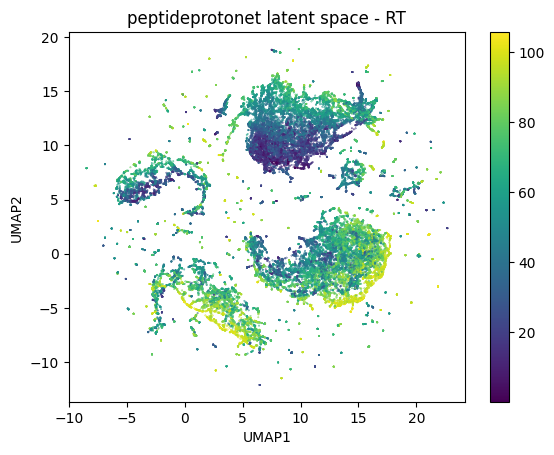

In [52]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=data['Retention time'].iloc[indices], s=0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.title('peptideprotonet latent space - RT')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'peptideprotonet latent space - Charge')

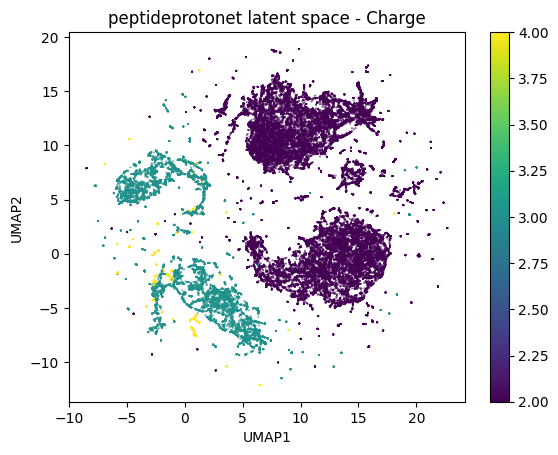

In [51]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=data['Charge'].iloc[indices], s=0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.title('peptideprotonet latent space - Charge')